In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

c:\venv\ilumpy\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Define font sizes
SIZE_DEFAULT = 20
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

In [3]:
import os, json, re
import pandas as pd

ROOT = "."
acc_mcr, acc_mer = {}, {}

def normalize_id(filename: str) -> str:
    stem = os.path.splitext(filename)[0]
    mol_id = stem.split("_", 1)[-1]
    mol_id = re.sub(r'(_(?:model|fold|seed|run)_\d+)$', '', mol_id)
    return mol_id

for root, _, files in os.walk(ROOT):
    base = os.path.basename(root).lower()

    if "mcr" in base:
        acc = acc_mcr
    elif "mer" in base:
        acc = acc_mer
    else:
        continue

    if "afinidade" in base or "affinity" in base:
        bloco = "aff"
    elif "confidence" in base:
        bloco = "conf"
    else:
        continue

    for file in files:
        if not file.endswith(".json"):
            continue

        id_ = normalize_id(file)

        with open(os.path.join(root, file), "r", encoding="utf-8") as f:
            data = json.load(f)
        flat = pd.json_normalize(data, sep=".").to_dict(orient="records")[0]

        # cria linha se não existir
        if id_ not in acc:
            acc[id_] = {"id": id_}

        # regra de mescla: aff tem prioridade sobre conf em chaves duplicadas
        if bloco == "aff":
            acc[id_].update(flat)  # escreve tudo
        else:  # bloco == "conf"
            for k, v in flat.items():
                if k not in acc[id_]:  # não sobrescreve valores já vindos de aff
                    acc[id_][k] = v

df_mcr = pd.DataFrame(acc_mcr.values()).sort_values("id").reset_index(drop=True)
df_mer = pd.DataFrame(acc_mer.values()).sort_values("id").reset_index(drop=True)


In [4]:
df_mer

,id,affinity_pred_value,affinity_probability_binary,affinity_pred_value1,affinity_probability_binary1,affinity_pred_value2,affinity_probability_binary2
0,Z102767654,2.125087,0.263040,2.592626,0.278740,1.657548,0.247340
1,Z104378302,2.233448,0.413694,2.164252,0.447208,2.302643,0.380180
2,Z104472798,2.356352,0.203175,2.839650,0.129829,1.873055,0.276522
3,Z104473324,2.254402,0.247567,2.804183,0.221283,1.704621,0.273851
4,Z104473344,2.284984,0.310226,1.757253,0.373968,2.812715,0.246484
...,...,...,...,...,...,...,...
310,Z969591530,1.838751,0.411935,2.048664,0.543417,1.628837,0.280453
311,Z976688982,1.547742,0.156012,2.001907,0.082622,1.093576,0.229402
312,Z979311300,1.992543,0.341275,2.357494,0.341367,1.627591,0.341182
313,Z99600464,2.787987,0.214429,2.779527,0.119699,2.796447,0.309159


### MCR

<Figure size 1000x600 with 0 Axes>

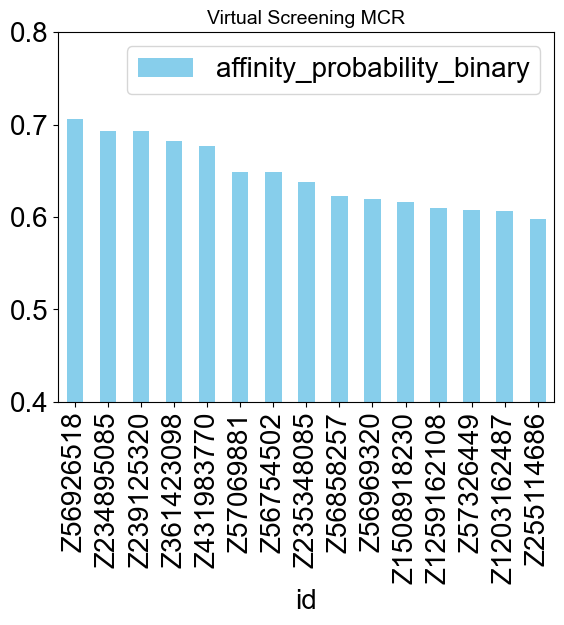

230      Z56926518
112     Z234895085
118     Z239125320
148     Z361423098
174     Z431983770
243      Z57069881
203      Z56754502
116     Z235348085
213      Z56858257
237      Z56969320
96     Z1508918230
88     Z1259162108
266      Z57326449
81     Z1203162487
120     Z255114686
Name: id, dtype: object


In [5]:
top_15_mcr = df_mcr.sort_values("affinity_probability_binary", ascending=False).head(15)

plt.figure(figsize=(10,6))
top_15_mcr.plot(x='id', y='affinity_probability_binary', kind="bar", color="skyblue")
plt.title("Virtual Screening MCR", fontsize=14)
plt.ylim(0.4,0.80)
plt.show()

print(top_15_mcr["id"])

# colcar confiancia!!! 

### MER

<Figure size 1000x600 with 0 Axes>

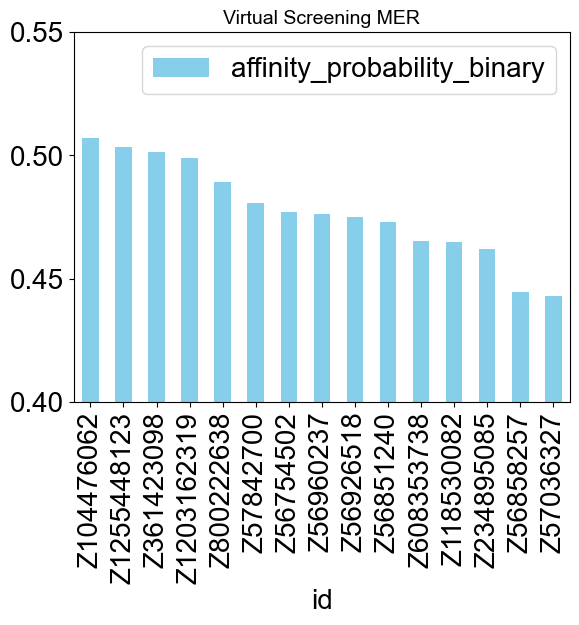

16      Z104476062
87     Z1255448123
148     Z361423098
80     Z1203162319
295     Z800222638
277      Z57842700
203      Z56754502
236      Z56960237
230      Z56926518
210      Z56851240
287     Z608353738
59      Z118530082
112     Z234895085
213      Z56858257
239      Z57036327
Name: id, dtype: object


In [11]:
top_15_mer = df_mer.sort_values("affinity_probability_binary", ascending=False).head(15)

plt.figure(figsize=(10,6))
top_15_mer.plot(x='id', y='affinity_probability_binary', kind="bar", color="skyblue")
plt.ylim(0.4,0.55)
plt.title("Virtual Screening MER", fontsize=14)
plt.show()

print(top_15_mer["id"])

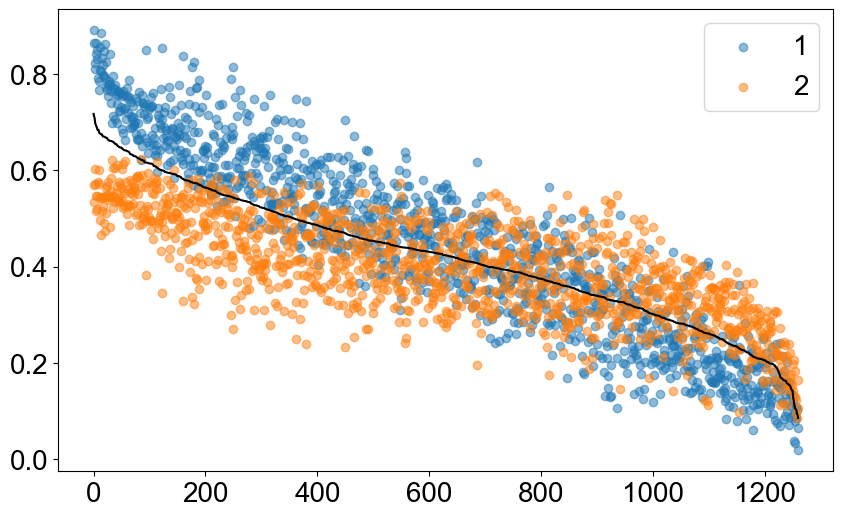

In [17]:
df_mer_sorted = df_mer.sort_values("affinity_probability_binary", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.scatter(df_mer_sorted.index, df_mer_sorted["affinity_probability_binary1"], alpha=0.5, label="1")
plt.scatter(df_mer_sorted.index, df_mer_sorted["affinity_probability_binary2"], alpha=0.5, label="2")
plt.plot(df_mer_sorted.index, df_mer_sorted["affinity_probability_binary"], color="blacK")
plt.legend()

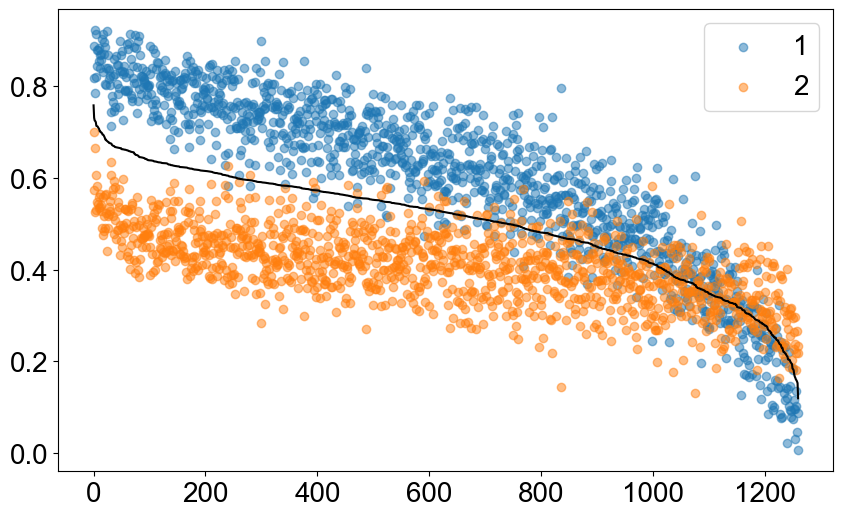

In [18]:
df_mcr_sorted = df_mcr.sort_values("affinity_probability_binary", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.scatter(df_mcr_sorted.index, df_mcr_sorted["affinity_probability_binary1"], alpha=0.5, label="1")
plt.scatter(df_mcr_sorted.index, df_mcr_sorted["affinity_probability_binary2"], alpha=0.5, label="2")
plt.plot(df_mcr_sorted.index, df_mcr_sorted["affinity_probability_binary"], color="blacK")
plt.legend()

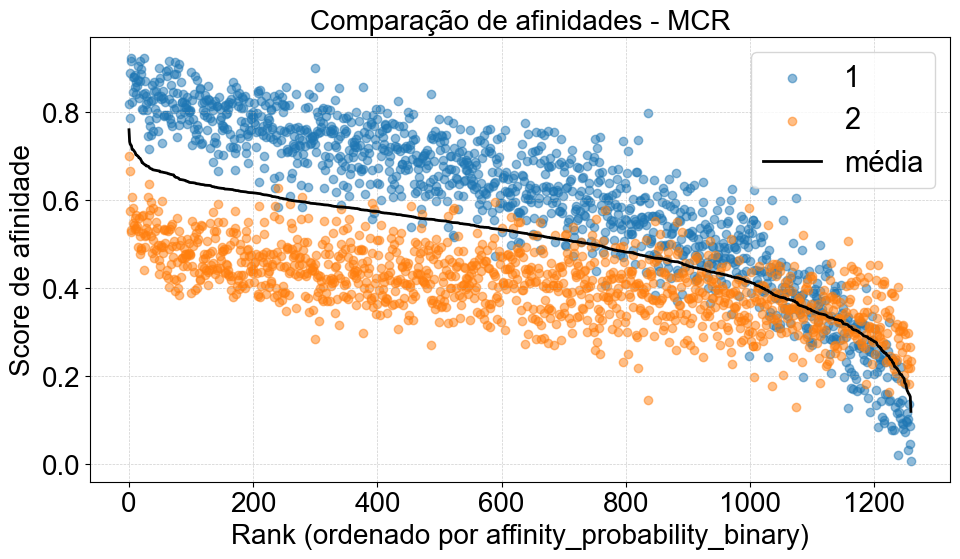

In [19]:
df_mcr_sorted = df_mcr.sort_values("affinity_probability_binary", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.scatter(df_mcr_sorted.index, df_mcr_sorted["affinity_probability_binary1"], alpha=0.5, label="1")
plt.scatter(df_mcr_sorted.index, df_mcr_sorted["affinity_probability_binary2"], alpha=0.5, label="2")
plt.plot(df_mcr_sorted.index, df_mcr_sorted["affinity_probability_binary"], color="black", linewidth=2, label="média")

plt.title("Comparação de afinidades - MCR")
plt.xlabel("Rank (ordenado por affinity_probability_binary)")
plt.ylabel("Score de afinidade")
plt.legend(fontsize=21)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


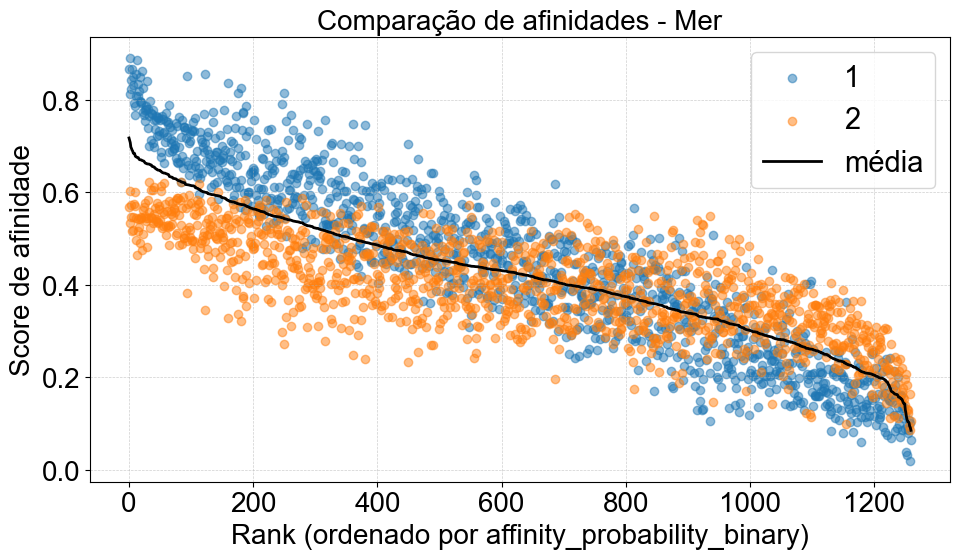

In [20]:
df_mer_sorted = df_mer.sort_values("affinity_probability_binary", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.scatter(df_mcr_sorted.index, df_mer_sorted["affinity_probability_binary1"], alpha=0.5, label="1")
plt.scatter(df_mcr_sorted.index, df_mer_sorted["affinity_probability_binary2"], alpha=0.5, label="2")
plt.plot(df_mcr_sorted.index, df_mer_sorted["affinity_probability_binary"], color="black", linewidth=2, label="média")

plt.title("Comparação de afinidades - Mer")
plt.xlabel("Rank (ordenado por affinity_probability_binary)")
plt.ylabel("Score de afinidade")
plt.legend(fontsize=21)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


### Relações entre as variáveis

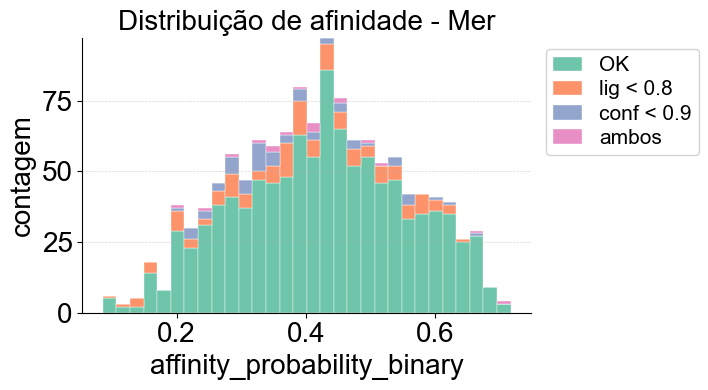

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== escolha a paleta =====
PAL = "set2"   # "tableau" | "set2" | "muted"

PALETTES = {
    # tons vivos, equilibrados (Tableau 10)
    "tableau": {
        "OK":   "#4E79A7",  # azul
        "LIG":  "#F28E2B",  # laranja
        "CONF": "#E15759",  # vermelho
        "BOTH": "#76B7B2",  # teal
    },
    # Set2 (mais suave)
    "set2": {
        "OK":   "#66C2A5",  # verde-água
        "LIG":  "#FC8D62",  # laranja
        "CONF": "#8DA0CB",  # azul-lilás
        "BOTH": "#E78AC3",  # rosa
    },
    # Muted (alto contraste sem “gritar”)
    "muted": {
        "OK":   "#3B7EA1",  # azul petróleo
        "LIG":  "#D17C2E",  # cobre
        "CONF": "#C33C3C",  # vermelho tijolo
        "BOTH": "#7A6BB7",  # roxo
    },
}
COL = PALETTES[PAL]

# ===== seus dados =====
df = df_mer  # ou df_mcr

aff = pd.to_numeric(df["affinity_probability_binary"], errors="coerce")
conf = pd.to_numeric(df["confidence_score"], errors="coerce")
lig  = pd.to_numeric(df["ligand_iptm"], errors="coerce")

mask = aff.notna() & conf.notna() & lig.notna()
aff, conf, lig = aff[mask], conf[mask], lig[mask]

fail_both = (conf < 0.9) & (lig < 0.8)
fail_conf = (conf < 0.9) & ~(lig < 0.8)
fail_lig  = ~(conf < 0.9) & (lig < 0.8)
ok        = ~(fail_both | fail_conf | fail_lig)

bin_edges = np.histogram_bin_edges(aff, bins=30)
lefts, widths = bin_edges[:-1], np.diff(bin_edges)

c_ok,   _ = np.histogram(aff[ok],        bins=bin_edges)
c_lig,  _ = np.histogram(aff[fail_lig],  bins=bin_edges)
c_conf, _ = np.histogram(aff[fail_conf], bins=bin_edges)
c_both, _ = np.histogram(aff[fail_both], bins=bin_edges)

fig, ax = plt.subplots(figsize=(7.5, 4.3))

ax.bar(lefts, c_ok,   width=widths, align="edge", alpha=0.95,
       edgecolor="white", linewidth=0.3, label="OK",         color=COL["OK"])
ax.bar(lefts, c_lig,  width=widths, align="edge", alpha=0.95,
       bottom=c_ok, edgecolor="white", linewidth=0.3, label="lig < 0.8",  color=COL["LIG"])
ax.bar(lefts, c_conf, width=widths, align="edge", alpha=0.95,
       bottom=c_ok+c_lig, edgecolor="white", linewidth=0.3, label="conf < 0.9", color=COL["CONF"])
ax.bar(lefts, c_both, width=widths, align="edge", alpha=0.95,
       bottom=c_ok+c_lig+c_conf, edgecolor="white", linewidth=0.3, label="ambos",     color=COL["BOTH"])

ax.set_xlabel("affinity_probability_binary")
ax.set_ylabel("contagem")
ax.set_title(f"Distribuição de afinidade - Mer")

ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(
    fontsize=15, markerscale=0.9, handlelength=1.4,
    labelspacing=0.25, borderpad=0.35, framealpha=0.85,
    bbox_to_anchor=(1.01, 1), loc="upper left"
)

plt.tight_layout()
plt.show()


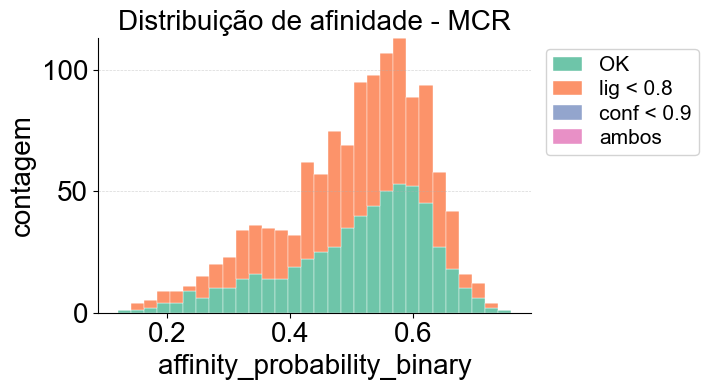

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== escolha a paleta =====
PAL = "set2"   # "tableau" | "set2" | "muted"

PALETTES = {
    # tons vivos, equilibrados (Tableau 10)
    "tableau": {
        "OK":   "#4E79A7",  # azul
        "LIG":  "#F28E2B",  # laranja
        "CONF": "#E15759",  # vermelho
        "BOTH": "#76B7B2",  # teal
    },
    # Set2 (mais suave)
    "set2": {
        "OK":   "#66C2A5",  # verde-água
        "LIG":  "#FC8D62",  # laranja
        "CONF": "#8DA0CB",  # azul-lilás
        "BOTH": "#E78AC3",  # rosa
    },
    # Muted (alto contraste sem “gritar”)
    "muted": {
        "OK":   "#3B7EA1",  # azul petróleo
        "LIG":  "#D17C2E",  # cobre
        "CONF": "#C33C3C",  # vermelho tijolo
        "BOTH": "#7A6BB7",  # roxo
    },
}
COL = PALETTES[PAL]

# ===== seus dados =====
df = df_mcr  # ou df_mcr

aff = pd.to_numeric(df["affinity_probability_binary"], errors="coerce")
conf = pd.to_numeric(df["confidence_score"], errors="coerce")
lig  = pd.to_numeric(df["ligand_iptm"], errors="coerce")

mask = aff.notna() & conf.notna() & lig.notna()
aff, conf, lig = aff[mask], conf[mask], lig[mask]

fail_both = (conf < 0.9) & (lig < 0.8)
fail_conf = (conf < 0.9) & ~(lig < 0.8)
fail_lig  = ~(conf < 0.9) & (lig < 0.8)
ok        = ~(fail_both | fail_conf | fail_lig)

bin_edges = np.histogram_bin_edges(aff, bins=30)
lefts, widths = bin_edges[:-1], np.diff(bin_edges)

c_ok,   _ = np.histogram(aff[ok],        bins=bin_edges)
c_lig,  _ = np.histogram(aff[fail_lig],  bins=bin_edges)
c_conf, _ = np.histogram(aff[fail_conf], bins=bin_edges)
c_both, _ = np.histogram(aff[fail_both], bins=bin_edges)

fig, ax = plt.subplots(figsize=(7.5, 4.3))

ax.bar(lefts, c_ok,   width=widths, align="edge", alpha=0.95,
       edgecolor="white", linewidth=0.3, label="OK",         color=COL["OK"])
ax.bar(lefts, c_lig,  width=widths, align="edge", alpha=0.95,
       bottom=c_ok, edgecolor="white", linewidth=0.3, label="lig < 0.8",  color=COL["LIG"])
ax.bar(lefts, c_conf, width=widths, align="edge", alpha=0.95,
       bottom=c_ok+c_lig, edgecolor="white", linewidth=0.3, label="conf < 0.9", color=COL["CONF"])
ax.bar(lefts, c_both, width=widths, align="edge", alpha=0.95,
       bottom=c_ok+c_lig+c_conf, edgecolor="white", linewidth=0.3, label="ambos",     color=COL["BOTH"])

ax.set_xlabel("affinity_probability_binary")
ax.set_ylabel("contagem")
ax.set_title(f"Distribuição de afinidade - MCR")

ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(
    fontsize=15, markerscale=0.9, handlelength=1.4,
    labelspacing=0.25, borderpad=0.35, framealpha=0.85,
    bbox_to_anchor=(1.01, 1), loc="upper left"
)

plt.tight_layout()
plt.show()


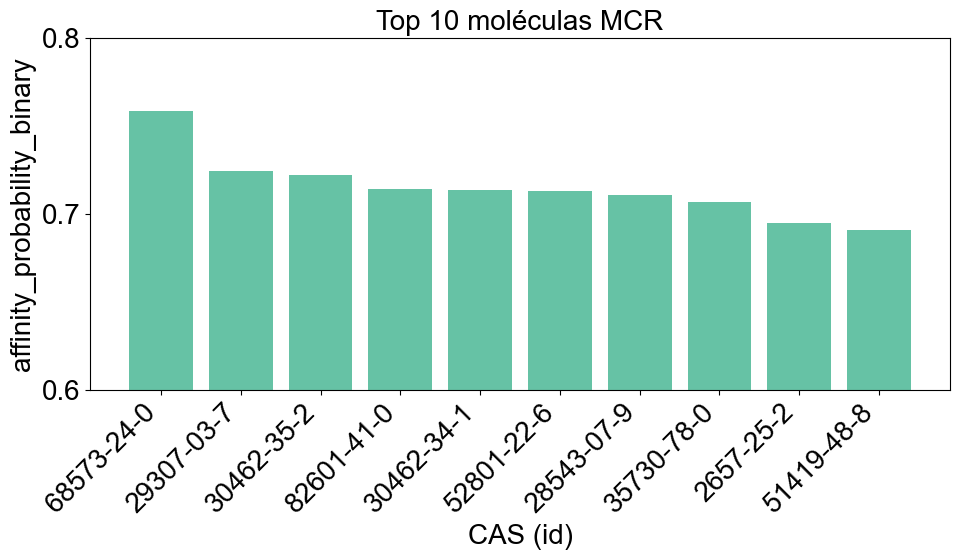

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# escolha o conjunto
df = df_mcr   # troque para df_mcr se quiser o outro

# garante colunas numéricas
aff = pd.to_numeric(df["affinity_probability_binary"], errors="coerce")
conf = pd.to_numeric(df["confidence_score"], errors="coerce")
lig  = pd.to_numeric(df["ligand_iptm"], errors="coerce")

# filtros
mask = aff.notna() & (conf >= 0.9) & (lig >= 0.8)

df_ok = df.loc[mask, ["id", "affinity_probability_binary"]].copy()
df_ok = df_ok.sort_values("affinity_probability_binary", ascending=False).head(10)

# --- Plot: ranking top-10 por afinidade, eixo X = CAS (id) ---
plt.figure(figsize=(10,6))
plt.bar(df_ok["id"], df_ok["affinity_probability_binary"], color= "#66C2A5")
plt.xlabel("CAS (id)")
plt.ylabel("affinity_probability_binary")
plt.title("Top 10 moléculas MCR")
plt.xticks(rotation=45, ha="right")
plt.ylim([0.6,0.8])
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.tight_layout()
plt.show()

df_ok_mcr = df_ok.sort_values("affinity_probability_binary", ascending=False).head(10)

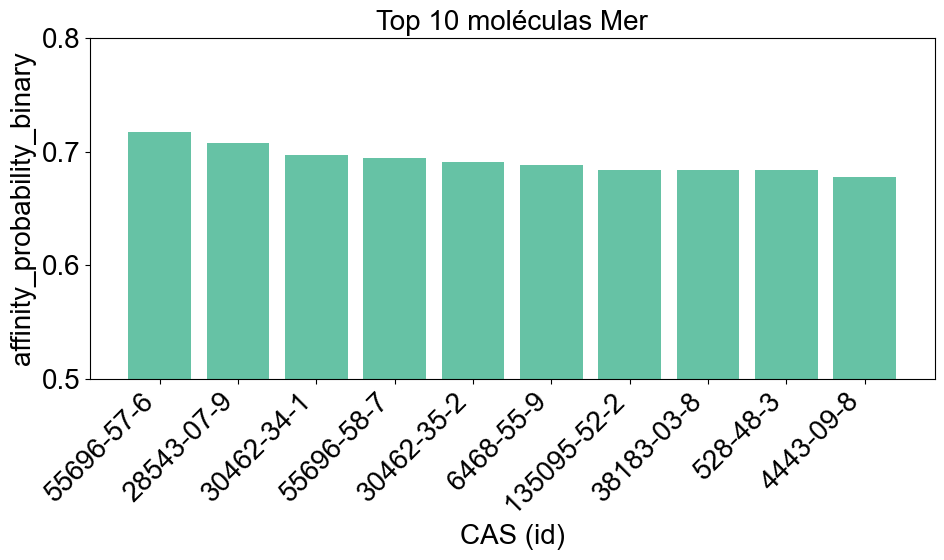

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# escolha o conjunto
df = df_mer   # troque para df_mcr se quiser o outro

# garante colunas numéricas
aff = pd.to_numeric(df["affinity_probability_binary"], errors="coerce")
conf = pd.to_numeric(df["confidence_score"], errors="coerce")
lig  = pd.to_numeric(df["ligand_iptm"], errors="coerce")

# filtros
mask = aff.notna() & (conf >= 0.9) & (lig >= 0.8)

df_ok = df.loc[mask, ["id", "affinity_probability_binary"]].copy()
df_ok = df_ok.sort_values("affinity_probability_binary", ascending=False).head(10)

# --- Plot: ranking top-10 por afinidade, eixo X = CAS (id) ---
plt.figure(figsize=(10,6))
plt.bar(df_ok["id"], df_ok["affinity_probability_binary"], color= "#66C2A5")
plt.xlabel("CAS (id)")
plt.ylabel("affinity_probability_binary")
plt.ylim([0.5,0.8])
plt.title("Top 10 moléculas Mer")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_ok_mer = df_ok.sort_values("affinity_probability_binary", ascending=False).head(10)

In [143]:
comuns = set(df_ok_mcr["id"]) & set(df_ok_mer["id"])
print(comuns)

{'30462-35-2', '28543-07-9', '30462-34-1'}


In [27]:
df_ok_mer

,id,affinity_probability_binary
850,55696-57-6,0.717079
413,28543-07-9,0.707321
446,30462-34-1,0.697380
851,55696-58-7,0.694404
447,30462-35-2,0.690815
971,6468-55-9,0.688494
123,135095-52-2,0.684078
525,38183-03-8,0.683928
781,528-48-3,0.683684
584,4443-09-8,0.678133


In [29]:
print(df_ok_mer['id'])

850     55696-57-6
413     28543-07-9
446     30462-34-1
851     55696-58-7
447     30462-35-2
971      6468-55-9
123    135095-52-2
525     38183-03-8
781       528-48-3
584      4443-09-8
Name: id, dtype: object


In [31]:
print(df_ok_mcr['id'])

1016    68573-24-0
428     29307-03-7
447     30462-35-2
1147    82601-41-0
446     30462-34-1
782     52801-22-6
413     28543-07-9
505     35730-78-0
389      2657-25-2
729     51419-48-8
Name: id, dtype: object


### Sem filtros 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# escolha o conjunto
df = df_mcr   # troque para df_mcr se quiser o outro

# garante colunas numéricas
aff = pd.to_numeric(df["affinity_probability_binary"], errors="coerce")
conf = pd.to_numeric(df["confidence_score"], errors="coerce")
lig  = pd.to_numeric(df["ligand_iptm"], errors="coerce")

# filtros
mask = aff.notna() & (conf >= 0.9) & (lig >= 0.8)

df_ok = df.copy()
df_ok = df_ok.sort_values("affinity_probability_binary", ascending=False).head(10)

# --- Plot: ranking top-10 por afinidade, eixo X = CAS (id) ---
plt.figure(figsize=(10,6))
plt.bar(df_ok["id"], df_ok["affinity_probability_binary"], color= "#66C2A5")
plt.xlabel("CAS (id)")
plt.ylabel("affinity_probability_binary")
plt.title("Top 10 moléculas MCR")
plt.xticks(rotation=45, ha="right")
plt.ylim([0.6,0.8])
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.tight_layout()
plt.show()

df_ok_mcr = df_ok.sort_values("affinity_probability_binary", ascending=False).head(10)